In [1]:
## 10000 events gets me to 5 sigma (5.07) with S+B vs B-only separation
## 50000 events gets me to 5 sigma (5.13) with B-only rejection

In [2]:
## try H->gg case
import numpy as np
from numba_stats import expon_pdf, expon_cdf, norm_pdf, norm_cdf
from scipy.stats import truncexpon, truncnorm
import matplotlib.pyplot as plt
np.random.seed(210187)
from tabulate import tabulate

mrange = (100,160)
mbins = 50
lb = 40
mu = 125
sg = 1
f = 0.01

# define normalised s+b pdfs with rapid evaluation from numba_stats
def spdf(x,mu=mu,sg=sg):
    sn = np.diff( norm_cdf(mrange,mu,sg) )
    return norm_pdf(x,mu,sg) / sn

def bpdf(x,lb=lb):
    bn = np.diff( expon_cdf(mrange,mrange[0],lb) )
    return expon_pdf(x,mrange[0],lb) / bn
    
# also make definitions using scipy stats that can be used for generation
sig = truncnorm( (mrange[0]-mu)/sg, (mrange[1]-mu)/sg, mu, sg)
bkg = truncexpon( (mrange[1]-mrange[0])/lb, mrange[0], lb)


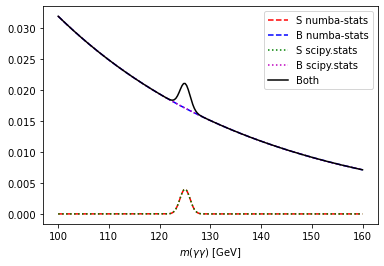

In [3]:
# better plot these to check they do what we want

x = np.linspace(mrange[0],mrange[1],200)


s = f * spdf(x)
b = (1-f) * bpdf(x)

fig, ax = plt.subplots()
ax.plot(x, f * spdf(x), 'r--', label='S numba-stats')
ax.plot(x, (1-f) * bpdf(x), 'b--', label='B numba-stats')
ax.plot(x, f*sig.pdf(x), 'g:', label='S scipy.stats')
ax.plot(x, (1-f)*bkg.pdf(x), 'm:', label='B scipy.stats')
ax.plot(x, s+b, 'k-', label='Both')
ax.legend()
_ = ax.set_xlabel('$m(\gamma\gamma)$ [GeV]')



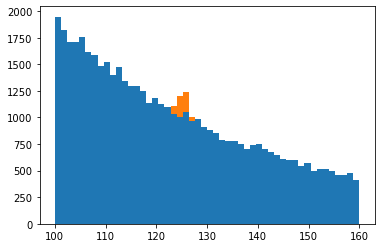

In [4]:
## generate s+b large samples (with poisson variation)
def gen(size,poiss=False,ax=None):

    nsig = np.random.poisson( f*size ) if poiss else int(f*size)
    nbkg = np.random.poisson( (1-f)*size ) if poiss else size-nsig
    
    # use scipy stats for this
    bkg_toy = bkg.rvs(size=nbkg)
    sig_toy = sig.rvs(size=nsig)
    toy = np.append(bkg_toy,sig_toy)
    
    if ax is not None:
        _ = ax.hist([bkg_toy,sig_toy], stacked=True, range=mrange, bins=mbins)
        #w, xe = np.histogram( toy, range=mrange, bins=mbins)
        #cx = 0.5*(xe[1:]+xe[:-1])
        #ax.errorbar(cx,w,yerr=w**0.5,fmt='ko', ms=2, capsize=2)
        
    return toy

fig, ax = plt.subplots()
toy = gen(50000,ax=ax)

######### SIGNAL + BACKGROUND FIT ########
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -5.815e+05                 │              Nfcn = 231              │
│ EDM = 0.000185 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───

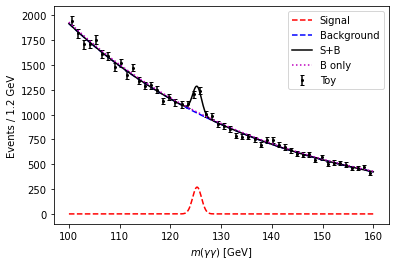

In [5]:
## FIT THE TOY WITH S+B and B-only
## And make the statistical comparison

from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
from scipy.stats import chi2 as chi2dist

# pdf for minuit (using numba-stats here gives supreme performance)
def pdf(x,ns,mu,sg,nb,lb):
    sig = spdf(x,mu,sg)
    bkg = bpdf(x,lb)
    return (ns+nb, ns*sig+nb*bkg)

# fit function (which can also plot) and does the stat comparison
def fit(toy, quiet=True, ax=None):

    # the minimiser
    m = Minuit( ExtendedUnbinnedNLL( toy, pdf ),
                ns = (1-f)*len(toy),
                nb = f*len(toy),
                mu = 125,
                sg = 1, 
                lb = 40
              )

    m.limits['ns'] = (1,len(toy))
    m.limits['nb'] = (1,len(toy))
    m.limits['mu'] = mrange
    m.limits['sg'] = (0,2)
    m.limits['lb'] = (5,100)
    
    # fit signal + background only
    m.fixed['ns'] = False
    m.fixed['mu'] = False
    m.fixed['sg'] = False
    m.migrad()
    m.hesse()
    if not quiet:
        print("######### SIGNAL + BACKGROUND FIT ########")
        print(m)
    sb_vals = np.array(m.values)
    sb_errs = np.array(m.errors)
    sb_fval = float(m.fval)
    
    # fit background only
    m.values['ns'] = 0
    m.fixed['ns'] = True
    m.fixed['mu'] = True
    m.fixed['sg'] = True
    m.migrad()
    m.hesse()
    if not quiet:
        print("######### BACKGROUND ONLY FIT ########")
        print(m)
    bo_vals = np.array(m.values)
    bo_errs = np.array(m.errors)
    bo_fval = float(m.fval)
    
    # do the plot if asked
    if ax is not None:
        # plot the toy
        w, xe = np.histogram( toy, range=mrange, bins=mbins)
        cx = 0.5*(xe[1:]+xe[:-1])
        ax.errorbar(cx,w,yerr=w**0.5,fmt='ko', ms=2, capsize=2, label='Toy')
    
        # plot the pdfs
        x = np.linspace(*mrange,400)
        norm = (mrange[1]-mrange[0])/mbins
    
        sb_sig = norm*sb_vals[m.var2pos['ns']]*spdf(x, sb_vals[m.var2pos['mu']], sb_vals[m.var2pos['sg']])
        sb_bkg = norm*sb_vals[m.var2pos['nb']]*bpdf(x, sb_vals[m.var2pos['lb']])
        bo_bkg = norm*bo_vals[m.var2pos['nb']]*bpdf(x, bo_vals[m.var2pos['lb']])
    
        ax.plot(x, sb_sig, 'r--', label='Signal')
        ax.plot(x, sb_bkg, 'b--', label='Background')
        ax.plot(x, sb_sig+sb_bkg, 'k-', label='S+B')
        ax.plot(x, bo_bkg, 'm:', label='B only')
        ax.legend()
        _ = ax.set_xlabel('$m(\gamma\gamma)$ [GeV]')
        _ = ax.set_ylabel('Events / {:.1f} GeV'.format((mrange[1]-mrange[0])/mbins))
        
    pr_rows = []
    
    # bin the toy and do the chi2 test
    w, xe = np.histogram( toy, range=mrange, bins=mbins)
    cx = 0.5*(xe[1:]+xe[:-1])
    norm = (mrange[1]-mrange[0])/mbins
    bo_bkg = norm*bo_vals[m.var2pos['nb']]*bpdf(cx, bo_vals[m.var2pos['lb']])
    chi2 = np.sum( (w-bo_bkg)**2/w )
    chi2_pdof = chi2 / (mbins-1)
    chi2_pval = 1 - chi2dist.cdf(chi2,(mbins-1))
    chi2_sig = chi2dist.ppf(1-chi2_pval,1)**0.5
    pr_rows.append( ['chisq', chi2, mbins-1, chi2_pval, chi2_sig])
    
    # do the LLR test
    dnll = 2*(bo_fval-sb_fval)
    dnll_sig = dnll**0.5
    dnll_pval = 1-chi2dist.cdf(dnll,1)
    pr_rows.append( ['LLR', dnll, 1, dnll_pval, dnll_sig])
    
    if not quiet:
        print(tabulate(pr_rows,headers=['Test','Statistic','ndof','p-val','significance']))
    
    # return some statistics of the results
    return ((chi2,chi2_pval,chi2_sig),(dnll,dnll_pval,dnll_sig))
    

## Test it out on our dummy toy ##
fig, ax = plt.subplots()
_ = fit(toy, quiet=False, ax=ax)



In [6]:
## let's run a few toys of different sizes and store the results
import pandas as pd

ntoys = 500

res = {}

for size in [1000,5000,10000,50000]:
    res[size] = pd.DataFrame()
    store = []
    for itoy in range(ntoys):
        toy = gen(size)
        chisq_stats, dnll_stats = fit(toy,quiet=True)
        store.append( np.array( [*chisq_stats, *dnll_stats], dtype=float ) )
    
    store = np.array(store)
    
    res[size]['chisq'] = store[:,0]
    res[size]['chisq_pval'] = store[:,1]
    res[size]['chisq_sig'] = store[:,2]
    res[size]['dnll'] = store[:,3]
    res[size]['dnll_pval'] = store[:,4]
    res[size]['dnll_sig'] = store[:,5]
    
    print('Sample Size', size)
    #print(res[size])
print('Done')

Sample Size 1000
Sample Size 5000
Sample Size 10000
Sample Size 50000
Done


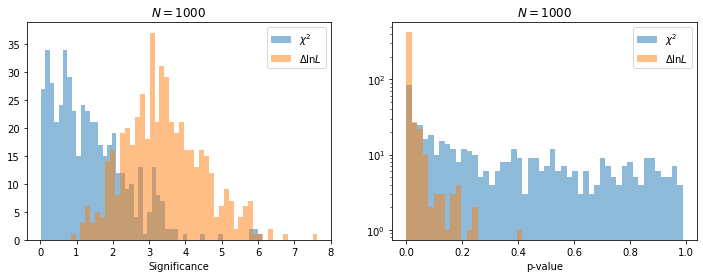

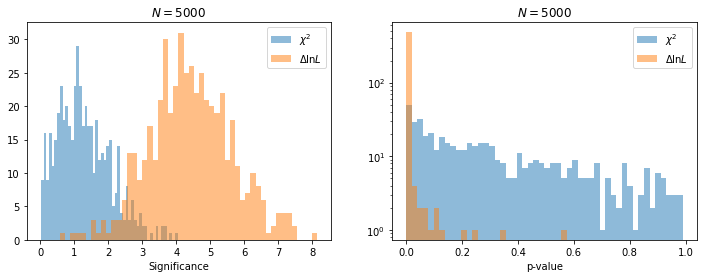

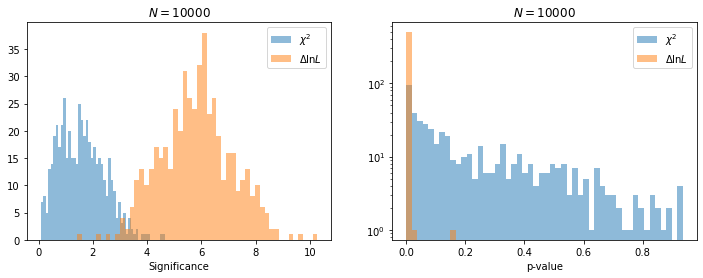

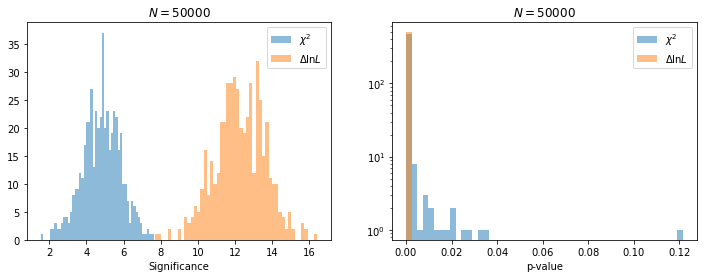

In [8]:
# plot the outcome (comparison of significance and p-value with the two methods)

for i, (size, df) in enumerate(res.items()):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].hist( df['chisq_sig'], alpha=0.5, bins=50, label='$\chi^2$')
    ax[0].hist( df['dnll_sig'], alpha=0.5, bins=50, label='$\Delta\ln L$')
    ax[0].set_xlabel('Significance')
    ax[0].legend()
    ax[0].set_title('$N = {:d}$'.format(size))
    
    xrange = (0,max(df['chisq_pval']))
    ax[1].hist( df['chisq_pval'], alpha=0.5, bins=50, range=xrange,  label='$\chi^2$')
    ax[1].hist( df['dnll_pval'], alpha=0.5, bins=50, range=xrange,label='$\Delta\ln L$')
    ax[1].set_xlabel('p-value')
    ax[1].legend()
    ax[1].set_yscale('log')
    ax[1].set_title('$N = {:d}$'.format(size))